# Import Libraries

In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard


from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 1. Code Configurations

In [7]:
VIDEO_DIR = "UCF50"
FRAMES_PER_CLIP = 25
IMAGE_SIZE = (64, 64)

# 2. Select Action Recognition Categories

In [8]:
# Choose actions to train on
selected_actions = ["Basketball", "Biking", "HorseRiding"]

In [4]:
# Setup the labels dictionary for the selected actions
label_dict = {}                                                     # {'action_name': idx}
for idx, action in enumerate(selected_actions):
    label_dict[action] = idx

# 3. Extract Video Frames

In [5]:
# This function extracts a specific number of evenly-spaced frames from a video file
def extract_video_frames(filepath):
    # Open the video file using OpenCV's VideoCapture
    capture = cv2.VideoCapture(filepath)
    # Get the total number of frames in the video
    total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # If the video has fewer frames than needed, return None
    if total_frames < FRAMES_PER_CLIP:
        capture.release()
        return None

    # Create an array of evenly-spaced frame indices to extract
    selected_frames = np.linspace(0, total_frames-1, FRAMES_PER_CLIP, dtype=int)
    frames_list = []                                                # list of frames

    # Loop through each selected frame index
    for frame_num in selected_frames:
        # Set the video position to the current frame number
        capture.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        # Read the frame at the current position
        success, frame = capture.read()
        # If frame couldn't be read, abort and return None
        if not success:
            capture.release()
            return None
        # Resize the frame to the dimensions specified by IMAGE_SIZE
        frame_resized = cv2.resize(frame, IMAGE_SIZE)
        # Add the resized frame to the collection
        frames_list.append(frame_resized)

    # Properly close the video file
    capture.release()
    
    # Return the collection of frames as a NumPy array
    return np.array(frames_list)

# 4. Create the Dataset

In [9]:
# Initialize empty lists to store processed video data and corresponding labels
all_videos, all_labels = [], []

# Iterate through each action category and its assigned ID from the label dictionary
for action, action_id in label_dict.items():
    # Construct the path to the folder containing videos for the current action
    action_folder = os.path.join(VIDEO_DIR, action)
    
    # Iterate through each video file in the current action folder
    for vid_file in os.listdir(action_folder):
        # Create the full path to the current video file
        clip_path = os.path.join(action_folder, vid_file)
        
        # Extract frames from the current video using the extraction function
        frames = extract_video_frames(clip_path)
        
        # Only process videos that returned valid frames
        if frames is not None:
            all_videos.append(frames)                               # Add the extracted frames to our collection of processed videos
            all_labels.append(action_id)                            # Store the corresponding action ID (label) for this video

# 5. Data Pre-processing

In [10]:
# Convert the list of videos to a numpy array and normalize pixel values
all_videos = np.array(all_videos).astype('float32') / 255.0

# Convert integer labels to one-hot encoded vectors
all_labels = to_categorical(all_labels, num_classes=len(label_dict))

# 6. Data Preparation

In [11]:
# Split data
train_videos, test_videos, train_labels, test_labels = train_test_split(all_videos, all_labels, test_size=0.25, random_state=123, stratify=all_labels)

In [12]:
# Input shape handling
train_videos = train_videos.reshape(-1, FRAMES_PER_CLIP, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
test_videos = test_videos.reshape(-1, FRAMES_PER_CLIP, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

# 7. Model Architecture

In [73]:
def create_convlstm_model():
    '''
    This function creates a ConvLSTM model for video classification.
    The model combines ConvLSTM2D layers for spatio-temporal feature extraction with additional layers for better performance.
    
    Returns:
        model: The constructed improved ConvLSTM model.
    '''
    
    # 1. Initialize a Sequential model
    model = Sequential()
    
    # 2. Model Architecture
    # ---------------------
    # 2.1. ConvLSTM2D Layer 1 - with Batch Normalization
    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh',
                         data_format='channels_last', recurrent_dropout=0.2, return_sequences=True,
                         input_shape=(FRAMES_PER_CLIP, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    # 2.2. ConvLSTM2D Layer 2 - with Batch Normalization
    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh',
                         data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    # 2.3. ConvLSTM2D Layer 3 - with Batch Normalization
    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh',
                         data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    # 2.4. ConvLSTM2D Layer 4 - with Batch Normalization
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='tanh',
                         data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    # 2.5. Add regular LSTM layer to further process temporal data
    model.add(Flatten())                                       # Flatten the output of the ConvLSTM layers
    
    # 2.6. Fully Connected Dense Layer for Classification
    model.add(Dense(256, activation='tanh'))
    model.add(Dropout(0.4))
    model.add(Dense(len(label_dict), activation='softmax'))
    # ---------------------
    
    # 3. Display the model summary
    model.summary()
    
    return model

# 8. Compile the Model

In [74]:
# Create the ConvLSTM model
convlstm_model = create_convlstm_model()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_39 (ConvLSTM2D  (None, 25, 62, 62, 4)     1024      
 )                                                               
                                                                 
 batch_normalization_29 (Ba  (None, 25, 62, 62, 4)     16        
 tchNormalization)                                               
                                                                 
 max_pooling3d_39 (MaxPooli  (None, 25, 31, 31, 4)     0         
 ng3D)                                                           
                                                                 
 time_distributed_41 (TimeD  (None, 25, 31, 31, 4)     0         
 istributed)                                                     
                                                                 
 conv_lstm2d_40 (ConvLSTM2D  (None, 25, 29, 29, 8)   

In [75]:
# Compile the model
convlstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [76]:
# Add Callbacks
# 1. Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Number of epochs with no improvement after which training will stop
    restore_best_weights=True,
    verbose=1
)

# 2. TensorBoard - visualize training metrics
tensorboard = TensorBoard(
    log_dir='./logs',
    histogram_freq=1
)

call_backs = [early_stopping, tensorboard]

# 9. Train the Model

In [77]:
# 10. Train (Batch Size & Epochs Modified)
history = convlstm_model.fit(train_videos, train_labels,
                             validation_data=(test_videos, test_labels),
                             epochs=50, batch_size=4,
                             shuffle=True, validation_split=0.2,
                             callbacks=call_backs, verbose=1)

Epoch 1/50
88/88 [==============================] - 61s 580ms/step - loss: 1.7144 - accuracy: 0.4217 - val_loss: 1.5382 - val_accuracy: 0.4153
Epoch 2/50
88/88 [==============================] - 51s 575ms/step - loss: 1.2114 - accuracy: 0.4900 - val_loss: 1.4261 - val_accuracy: 0.4153
Epoch 3/50
88/88 [==============================] - 49s 560ms/step - loss: 1.0799 - accuracy: 0.5584 - val_loss: 1.7485 - val_accuracy: 0.4153
Epoch 4/50
88/88 [==============================] - 49s 554ms/step - loss: 1.0623 - accuracy: 0.5726 - val_loss: 1.3883 - val_accuracy: 0.4153
Epoch 5/50
88/88 [==============================] - 49s 557ms/step - loss: 0.9859 - accuracy: 0.5954 - val_loss: 1.2303 - val_accuracy: 0.4407
Epoch 6/50
88/88 [==============================] - 51s 571ms/step - loss: 0.9006 - accuracy: 0.6325 - val_loss: 1.0882 - val_accuracy: 0.4915
Epoch 7/50
88/88 [==============================] - 49s 557ms/step - loss: 0.8541 - accuracy: 0.6325 - val_loss: 0.9597 - val_accuracy: 0.5254

# 10. Plot Results

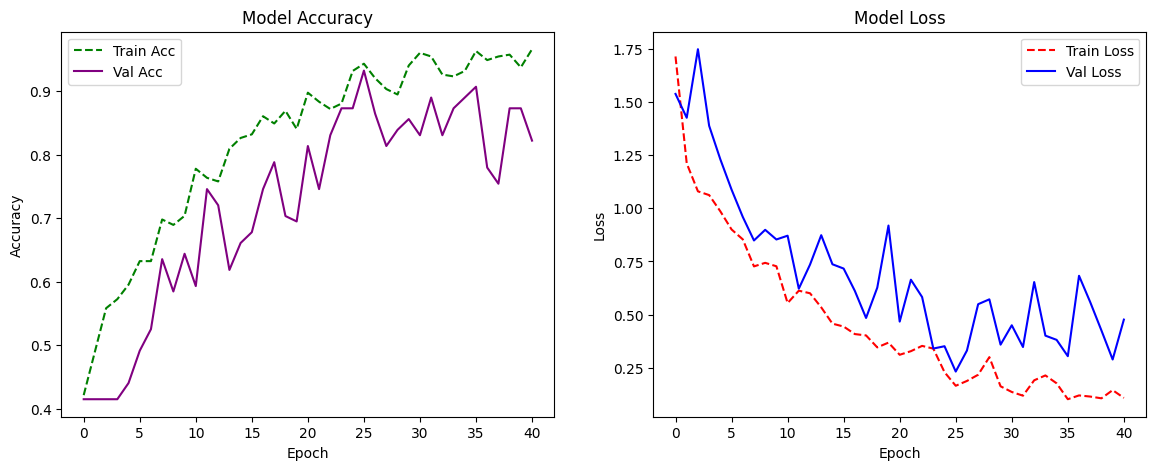

In [78]:
# Direct Plotting (Different Colors/Styles)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))


# Accuracy
ax[0].plot(history.history['accuracy'], color='green', linestyle='--', label='Train Acc')
ax[0].plot(history.history['val_accuracy'], color='purple', label='Val Acc')
ax[0].legend()
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')

# Loss
ax[1].plot(history.history['loss'], color='red', linestyle='--', label='Train Loss')
ax[1].plot(history.history['val_loss'], color='blue', label='Val Loss')
ax[1].legend()
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

plt.show()

# 11. Final Evaluation

In [79]:
# Evaluate the model on the test set
res = convlstm_model.evaluate(test_videos, test_labels)

4/4 [==============================] - 2s 440ms/step - loss: 0.2321 - accuracy: 0.9322


In [80]:
# Print the evaluation results
res

[0.23214639723300934, 0.9322034120559692]

# 12. Save the Model

In [81]:
# 13. Save (Optional, renamed for difference)
convlstm_model.save("action_classifier_model_v2.h5")

/home/ahmedmoussa/tfx_venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
